# Week 3 assessment - Segmenting and Clustering Neighborhoods in Toronto

## Part I - Creating a DataFrame of neighbourhoods in Toronto

Import necessary packages

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Acquire HTML code of Wikipedia page listing post codes of Toronto and open it with BeautifulSoup

In [2]:
page_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(page_source, 'html.parser')

Extract information from the table in the HTML code and organise in a DataFrame

In [3]:
# Extract column names from html soup
columns = [column_head.text.strip() for column_head in soup.table.find_all('th')]
# Create a dictionary with extracted column names
table_data = {column_name: [] for column_name in columns}
# Iterate over all rows in the table
for row in soup.table.find_all('tr'):
    # For each value in the table
    for value, column in zip(row.find_all('td'), columns):
        table_data[column].append(value.text.strip())
df = pd.DataFrame(table_data, columns=columns)

Arrange the DataFrame as instructed for this assessment

In [4]:
# Remove rows where Borough 'Not assigned'
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
# Set Neighbourhood equal to Borough where 'Not assigned'
df.Neighbourhood.replace('Not assigned', np.nan, inplace=True)
df.Neighbourhood.fillna(df.Borough, inplace=True)
# Find postcodes that span multiple neighbourhoods.
duplicated_postcodes = df.Postcode[df.duplicated(subset='Postcode', keep=False)].unique()
# For each of the postcodes with multiple neighourhoods
# assign the value to neighbourhood to be all neighbourhoods
# concatenated with ', '.
for postcode in duplicated_postcodes:
    row_indices = df[df.Postcode == postcode].index
    df.loc[row_indices[0]].Neighbourhood = ', '.join(df.loc[row_indices].Neighbourhood)
# Remove all the rows of postcodes that span multiple neighbourhoods
# except the first instance that was just changed.
df.drop_duplicates(subset='Postcode', keep='first', inplace=True)
# Reset index values
df.reset_index(drop=True, inplace=True)
# Sort by Postcode
df.sort_values('Postcode', inplace=True)

Display DataFrame contents

In [5]:
df

,Postcode,Borough,Neighbourhood
6,M1B,Scarborough,"Rouge, Malvern"
12,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
18,M1E,Scarborough,"Guildwood, Morningside, West Hill"
22,M1G,Scarborough,Woburn
26,M1H,Scarborough,Cedarbrae
32,M1J,Scarborough,Scarborough Village
38,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
44,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
51,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
58,M1N,Scarborough,"Birch Cliff, Cliffside West"


Display the number of rows in the DataFrame as instructed

In [6]:
print('Number of rows in the DataFrame: ' + str(df.shape[0]))

Number of rows in the DataFrame: 103


## Part II - Append latitude and longitude columns for each postcode in DataFrame

Create function for acquiring latitude and longitude values of a postcode using geocoder

In [7]:
import geocoder

def get_coordinates_for_toronto_postcode(postcode, max_attempts=10):
    lat_lng_coords = None
    # loop until you get the coordinates
    attempts = 0
    while(lat_lng_coords is None):
        attempts += 1
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
    # Extract latidue and longitude
    return lat_lng_coords

Attempt to retrieve latitude and longitude values using geocoder

In [8]:
# Retrieve data using geocoder
latitudes = []
longitudes = []
for postcode in df.Postcode:
    lat_lng_coords = get_coordinates_for_toronto_postcode(postcode)
    if lat_lng_coords is None:
        raise Exception('Failed to retrieve data using geocoder')
    else:
        latitudes.append(lat_lng_coords[0])
        longitudes.append(lat_lng_coords[1])
# Convert into dataframe
print('Latitude and longitude values retrieved succesfully with geocoder module')
df_latlng = pd.DataFrame({'Postcode': df.Postcode, 
                          'Latitude': latitudes, 
                          'Longitude': longtiudes})

In case geocoder failed, extract latitude and longitude values from the provided CSV file

In [9]:
df_latlng = pd.read_csv('Toronto_Postcode_Geospatial_Coordinates.csv')
df_latlng.rename(columns={'Postal Code': 'Postcode'}, inplace=True)

Merge latitude and longitude values to main DataFrame

In [10]:
df = df.merge(df_latlng, how='inner', on='Postcode')

Set index to be Postcode

In [11]:
df.set_index('Postcode', inplace=True)

Display current main DataFrame

In [12]:
df

,Borough,Neighbourhood,Latitude,Longitude
Postcode,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476
M1J,Scarborough,Scarborough Village,43.744734,-79.239476
M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476


## Part III - Exploring and clustering the neighbourhoods in Toronto

## Get data for each postcode from Foursquare

Set Foursquare API key values

In [13]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Get list of Food place categories

In [14]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION
    )
json_results = requests.get(url).json()
# Food places is 3rd on the of top level categories
results = json_results['response']['categories'][3]['categories']

In [15]:
# Extract shortName and categoryId for all food categories
categoryName = []
categoryId = []
for category in results:
    categoryName.append(category['shortName'])
    categoryId.append(category['id'])
# Format into DataFrame
df_categories = pd.DataFrame({'Name': categoryName, 'ID': categoryId})

Define function for counting number of venues of specific category near a specific location

In [16]:
def count_nearby_venues(latitude, longitude, categoryId, radius):
    limit = 50 # Maximum allowed matches per Foursquare query
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        categoryId, 
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)
            
    # make the GET request
    results = requests.get(url).json()
    
    # Get number of matches if available
    n = 0
    if isinstance(results, dict):
        if 'response' in results:
            if 'venues' in results['response']:
                if isinstance(results['response']['venues'], list):
                    n = len(results['response']['venues'])
    
#     # Check that limit is not being imposed
#     if n == limit:
#         print('Number of matches for {} was at limit. The number of matches may be incorrect.'.format(categoryId))
    
    return n

Acquire data from Foursquare on number of venues of each category at 1 km radius from each Postcode

In [17]:
radius = 1000
venue_counts = dict((category, []) for category in df_categories['Name'])
postcodes_fetched = 0
for latitude, longitude in zip(df['Latitude'], df['Longitude']):
    for category, categoryId in zip(df_categories['Name'], df_categories['ID']):
        count = count_nearby_venues(latitude, longitude, categoryId, radius)
        venue_counts[category].append(count)
    postcodes_fetched += 1
#     print('Postcodes fetched: {}'.format(postcodes_fetched))
df_venue_counts = pd.DataFrame(data=venue_counts, columns=list(df_categories['Name']), index=df['Postcode'])

Merge some categories and delete others

In [18]:
df_venue_counts['Café'] = df_venue_counts['Café'] \
                          + df_venue_counts.pop('Cafeteria') \
                          + df_venue_counts.pop('Coffee Shop')
df_venue_counts.drop('Restaurant', axis=1, inplace=True)

Create and Load `df_venue_counts` backup

In [19]:
df_venue_counts.to_pickle('Assessment_3_venue_counts.p')
df_venue_counts = pd.read_pickle('Assessment_3_venue_counts.p')

## Find food place categories that best separate different Postcodes

In [20]:
from sklearn.decomposition import PCA

Define function for returning column names that best separate different samples

In [21]:
def best_pca_columns(df, n_columns=3, n_components=3):
    pca = PCA(n_components=3)
    _ = pca.fit_transform(df)
    pc_contributions = np.sum(np.abs(pca.components_), axis=0)
    pca_max_contrib_var_indices = np.argsort(pc_contributions)[-n_columns:][::-1]
    
    return df.columns[pca_max_contrib_var_indices]

Some Postcodes have many more venues around them. To distinguish Postcodes based on the relative density of different food places, we must compute the proportion of each food place category seperately at each Postcode.
Here we define a function to do that.

In [22]:
def normalize_category_counts_for_each_postcode(df):
    return df.div(df.sum(axis=1), axis=0)

Compute normalized venue counts

In [23]:
df_venue_counts_normalized = normalize_category_counts_for_each_postcode(df_venue_counts)
# Replace NaN values with 0s
df_venue_counts_normalized.fillna(0, inplace=True)

Compute 3 food place categories that best separate Postcodes

In [24]:
main_categories = best_pca_columns(df_venue_counts_normalized)
print('The main food place categories for clustering Postcodes are:\n' + '\n'.join(main_categories))

The main food place categories for clustering Postcodes are:
Café
Asian
Fast Food


Only keep venue counts for main food place categories in `df_venues` and `df_venues_norm`

In [25]:
df_venues = df_venue_counts[main_categories]
df_venues_norm = df_venue_counts_normalized[main_categories]

Display distribution of remaining food place proportions across Postcodes

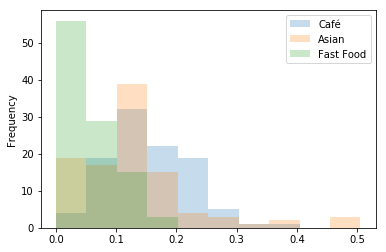

In [26]:
df_venues_norm.plot(kind='hist', alpha=0.25)
plt.show()

## Cluster Postcodes based on 3 main food place categories

In [27]:
from sklearn.cluster import KMeans

Compute labels with K-Means clustering

In [28]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_venues_norm)
df['foodie_category'] = kmeans.labels_

Display all datapoints and clusters in 3-D space

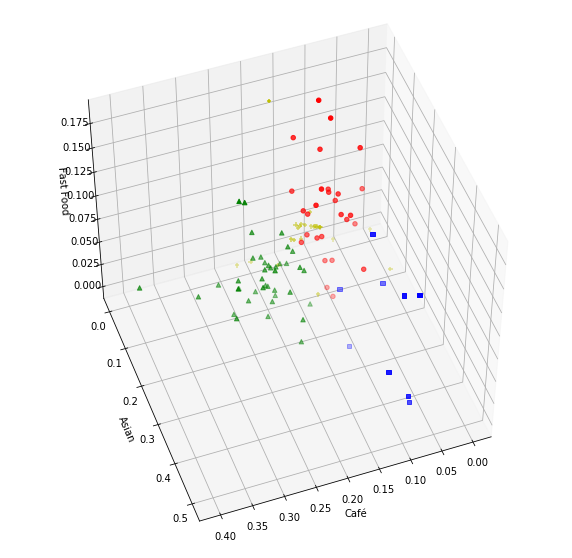

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

markers = ['o', '^', 's', '+']
colors = ['r', 'g', 'b', 'y']

for i in range(len(np.unique(df['foodie_category'].values))):
    idx = df['foodie_category'] == i
    x = df_venues_norm.loc[idx, df_venues_norm.columns[0]]
    y = df_venues_norm.loc[idx, df_venues_norm.columns[1]]
    z = df_venues_norm.loc[idx, df_venues_norm.columns[2]]
    ax.scatter(x, y, z, c=colors[i], marker=markers[i])

    
cat_names = df_venues_norm.columns
ax.set_xlabel(df_venues_norm.columns[0])
ax.set_ylabel(df_venues_norm.columns[1])
ax.set_zlabel(df_venues_norm.columns[2])

ax.view_init(elev=50, azim=70)

plt.show()

Display table for mean food venue counts for each label

In [30]:
cat_names = ['Red', 'Green', 'Blue', 'Yellow']
cat_vals = {}
for cat_nr in np.unique(df['foodie_category']):
    idx = df['foodie_category'] == cat_nr
    cat_vals[cat_names[cat_nr]] = df_venues.loc[idx, :].mean()
pd.DataFrame(cat_vals)

,Blue,Green,Red,Yellow
Café,5.666667,32.175,7.571429,81.769231
Asian,22.888889,20.050,8.892857,30.692308
Fast Food,3.444444,6.350,5.500000,28.269231


### Description of different Postcode categories
Descriptions of venue selection in 1 km radius from each postcode. The numbers in brackets are average counts in 1 km radius across all postcodes in this category.

The locations of these postcodes are illustrated below.
#### Blue Postcode
There are many more Asian food venues (23) than others. There are very few Cafes (6) and Fast Food places (3).

These locations are mostly in the outskirts of the city, furtherest from the city center.
#### Green Postcode
There are plenty of Cafes (32 on average) and also many Asian food venues (20), but very few Fast Food places.

The Green Postcodes are locations at the center of the city but not quite in downtown.
#### Red Postcode
There are rather few food places around at these postcodes. On average, only 8 Cafes, 9 Asian food venues and 6 Fast Food places.

These areas with very few food venues are located between the extremities of the city (Blue Postcodes) and the more central areas (Green Postcodes).
#### Yellow Postcode
There are more of each type of venue at these postcodes. The most common venue is Cafe (82), while Asian food venues (31) and Fast Food places (28) are roughly equally represented.

The Yellow Postcodes are located mostly in downtown, which explains the high density of food venues. However, there are a few locations scattered around Toronto where there are similar proportions of food venues.

## Display Postcodes on a map as clustered based on local proportions of food places

In [31]:
import folium

In [32]:
map_toronto = folium.Map(location=[df.Latitude.mean(), df.Longitude.mean()], zoom_start=11)
colors = ['red', 'green', 'blue', '#FFFF00']
# Add markers to map
for lat, lng, label, category in zip(df['Latitude'], df['Longitude'], df.index, df['foodie_category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[category],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
        ).add_to(map_toronto)  

map_toronto